In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'



from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *

2024-01-22 19:18:11.632010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from scipy.signal import resample

N_objects = 5000
noise_sigma = 1e-3
num_nyquist_samples_list = [4, 9, 16, 25, 36]
num_bootstrap_samples = 11
upsampling_factor = 64
max_epochs = 5000
confidence = 90

object_names = ['white_noise', 'delta_uniform', '8_deltas_uniform']

num_nyquist_samples = NUM_NYQUIST_SAMPLES


def white_noise_fn(upsampling_factor):
  # generate a random object at the lowest resolution
  objects = []
  for i in range(N_objects):  
    object = generate_random_object('white_noise', object_size=upsampling_factor*num_nyquist_samples_list[0])
    # upsample it
    object = resample(object, upsampled_signal_length)
    objects.append(object)
  # print(objects[0].shape)
  return np.array(objects) 

mi_by_object = {}
mi_by_object_hi = {}
mi_by_object_lo = {}
for name in object_names:
  print(name)
  mutual_information = []
  mi_hi = []
  mi_lo = []
  for num_nyquist_samples in tqdm(num_nyquist_samples_list):
    upsampled_signal_length = upsampling_factor*num_nyquist_samples
    
    if name == 'delta_uniform':
      objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
    elif name == '8_deltas_uniform':
      objects_fn = lambda :np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])
    else:
      objects_fn = lambda : white_noise_fn(upsampling_factor)

    runs = []
    for i in range(num_bootstrap_samples):
      initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(
          objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampling_factor*num_nyquist_samples,
          max_epochs=max_epochs, 
          )
      runs.append(optimized_mi)
    runs = np.array(runs)
    mutual_information.append(np.median(runs))
    mi_lo.append(np.percentile(np.array(runs), 100-confidence))
    mi_hi.append(np.percentile(np.array(runs), confidence))
  mi_by_object[name] = mutual_information
  mi_by_object_hi[name] = mi_hi
  mi_by_object_lo[name] = mi_lo

white_noise


  0%|          | 0/5 [00:00<?, ?it/s]

initial loss -1.4502874306394973
computing optimized mi


2024-01-22 19:19:44.898392: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


initial loss -1.3579217926031553
computing optimized mi
initial loss -1.4969520613526972
computing optimized mi
initial loss -1.0059531561772563
computing optimized mi
initial loss -1.432376311341168
computing optimized mi
initial loss -1.7085061929653094
computing optimized mi
initial loss -0.8852746611832356
computing optimized mi
initial loss -1.1604096030143247
computing optimized mi
initial loss -1.5803590786561355
computing optimized mi
initial loss -1.2135985768238107
computing optimized mi
initial loss -1.1052271885992606
computing optimized mi


 20%|██        | 1/5 [13:52<55:31, 832.92s/it]

initial loss -1.3803203704024816
computing optimized mi
initial loss -0.9294396880372078
computing optimized mi
initial loss -1.283598041948217
computing optimized mi
initial loss -1.25209244494461
computing optimized mi
initial loss -1.422331004731267
computing optimized mi
initial loss -1.6084805242829916
computing optimized mi
initial loss -1.0294167843922146
computing optimized mi
initial loss -1.249579052940868
computing optimized mi
initial loss -1.3526102822376258
computing optimized mi
initial loss -0.9619826449591468
computing optimized mi
initial loss -1.137001138936266
computing optimized mi


 40%|████      | 2/5 [40:48<1:04:39, 1293.02s/it]

initial loss -0.9785055749360158
computing optimized mi
initial loss -1.0539224742106186
computing optimized mi
initial loss -1.2345990905888433
computing optimized mi
initial loss -1.0746129171987335
computing optimized mi
initial loss -0.7915130057968283


2024-01-22 23:04:52.847624: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: jaxlib/gpu/solver_kernels.cc:584: operation gpusolverDnDsyevj( handle.get(), jobz, d.uplo, d.n, a, d.n, w, static_cast<double*>(work), d.lwork, info, params) failed: cuSolver internal error
 40%|████      | 2/5 [3:46:25<5:39:38, 6792.96s/it]2024-01-22 23:04:52.847667: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1079] failed to free device memory at 0x7fa6933cd600; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2024-01-22 23:04:52.847675: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1079] failed to free device memory at 0x7fa6933c9c00; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2024-01-22 23:04:52.847681: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1079] failed to free device memory at 0x7fa6933c9800; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encoun

ute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:584: operation gpusolverDnDsyevj( handle.get(), jobz, d.uplo, d.n, a, d.n, w, static_cast<double*>(work), d.lwork, info, params) failed: cuSolver internal error; current tracing scope: custom-call.8; current profiling annotation: XlaModule:#hlo_module=jit_convolve_and_loss,program_id=474#.
2024-01-22 23:04:52.848044: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1079] failed to free device memory at 0x7fa5bb455200; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered



ValueError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.custom_call' failed: jaxlib/gpu/solver_kernels.cc:584: operation gpusolverDnDsyevj( handle.get(), jobz, d.uplo, d.n, a, d.n, w, static_cast<double*>(work), d.lwork, info, params) failed: cuSolver internal error; current tracing scope: custom-call.8; current profiling annotation: XlaModule:#hlo_module=jit_convolve_and_loss,program_id=474#.

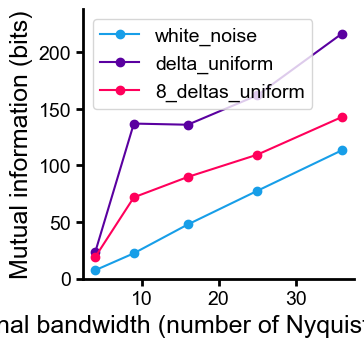

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

for object_name, mutual_information in mi_by_object.items():

    total_mi = np.array(mutual_information) * np.array(num_nyquist_samples_list)

    total_mi_hi = np.array(mi_by_object_hi[object_name]) * np.array(num_nyquist_samples_list)
    total_mi_lo = np.array(mi_by_object_lo[object_name]) * np.array(num_nyquist_samples_list)

    ax.plot(num_nyquist_samples_list, total_mi, 'o-', label=object_name)
    ax.fill_between(num_nyquist_samples_list, total_mi_lo, total_mi_hi, alpha=0.2)
    ax.set_xlabel('Signal bandwidth (number of Nyquist samples)')
    ax.set_ylabel('Mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))
    # ax.set(ylim=[0, 25])

clear_spines(ax)
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'mi_vs_bandwidth' + '.pdf', transparent=True)


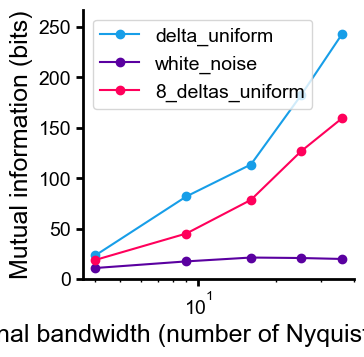

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

for object_name, mutual_information in mi_by_object.items():

    total_mi = np.array(mutual_information) * np.array(num_nyquist_samples_list)
    ax.semilogx(num_nyquist_samples_list, total_mi, 'o-', label=object_name)
    ax.set_xlabel('Signal bandwidth (number of Nyquist samples)')
    ax.set_ylabel('Mutual information (bits)')

    ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

clear_spines(ax)
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/1d_signals/' + 'mi_vs_bandwidth' + '.pdf', transparent=True)
